In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import norm

In [2]:
N = norm.cdf

### Parameters

In [3]:
STRIKE_PRICE = 100
STOCK_PRICE0 = 110

VOLATILITY = 0.2
RISK_FREE_RATE = 0.1

T_TO_EXP = 1.5 # YEARS
 
N_MC_SIMULATIONS = 1000
N_PATH = 10000

In [4]:
def mc_pricing(S0, r, sigm, T, N, N_path):
    dt = T / N
    times = np.linspace(0, T, N+1)
    
    # Initialize array: rows = time steps, columns = paths
    S = np.zeros((N + 1, N_path))
    S[0] = S0  # initial value for all paths

    for t in range(1, N + 1):
        Z = np.random.normal(size=N_path)  # generate one z per path
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigm**2) * dt + sigm * np.sqrt(dt) * Z)
    
    return S

In [5]:
type(int(N_MC_SIMULATIONS * T_TO_EXP))

int

In [6]:
mc_prices = mc_pricing(STOCK_PRICE0, RISK_FREE_RATE, VOLATILITY, T_TO_EXP, N_MC_SIMULATIONS, N_PATH)

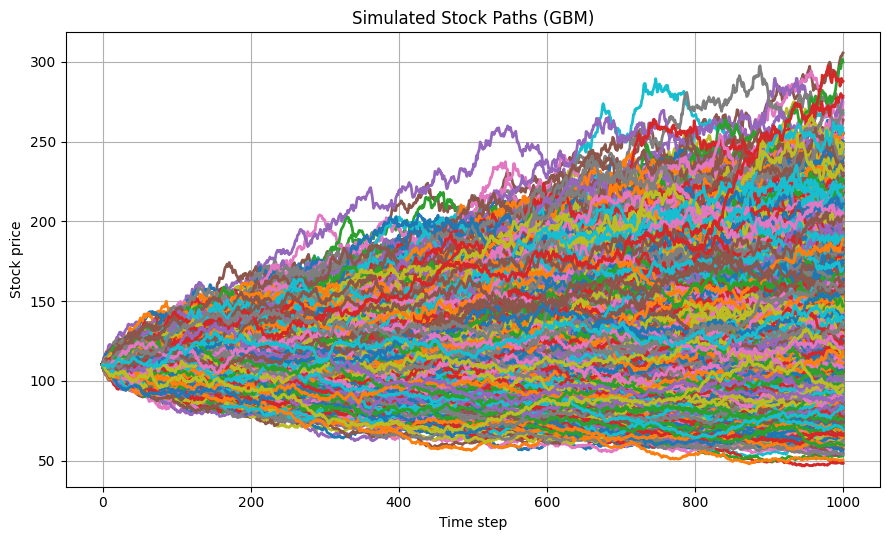

In [7]:
time_points = np.arange(mc_prices.shape[0])


plt.figure(figsize=(9, 5.5))

for i in range(mc_prices.shape[1]):
    plt.plot( time_points, mc_prices[:, i], lw=2.0)

plt.title("Simulated Stock Paths (GBM)")
plt.xlabel("Time step")
plt.ylabel("Stock price")
plt.grid(True)
plt.tight_layout()
plt.show()

## Compute call option prices using terminal MC prices and Black-Scholes formula (just for the check)

In [8]:
S_T = mc_prices[-1]
mc_call_price =np.mean(np.maximum((S_T - STRIKE_PRICE), 0.0)) * np.exp(-RISK_FREE_RATE * T_TO_EXP)

In [9]:
mc_call_price

np.float64(25.852720808793535)

In [10]:
def call_option(K, S0, r, sigm, T):
    d1 =  (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

    d2 = d1 - sigm*np.sqrt(T)

    p =  S0 * N(d1) - K * np.exp(-r*T) * N(d2)

    return p

In [11]:
call_option(STRIKE_PRICE, STOCK_PRICE0, RISK_FREE_RATE, VOLATILITY, T_TO_EXP)

np.float64(25.899980549802706)

In [12]:
def d1(K, S0, r, sigm, T):
    return (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

def d2(K, S0, r, sigm, T):
    return d1(K, S0, r, sigm, T) - sigm*np.sqrt(T)

def greek_delta(K, S0, r, sigm, T, opt_type):
    if opt_type == "call":
        delt = N(d1(K, S0, r, sigm, T))
    elif opt_type == "put":
        delt = N(d1(K, S0, r, sigm, T)) - 1
    
    return delt

In [13]:
def delta_neutral_hedge(delta_series, N_opt=1.0):
    delta_series = np.asarray(delta_series)
    target_stock = - delta_series * N_opt
    adjustments = np.diff(target_stock, prepend=0.0)  # trade at each step
    return target_stock, adjustments

In [14]:
# pick one path to hedge

S_path = mc_prices[:, 0]                        # shape (N_steps+1,)
N_steps = mc_prices.shape[0] - 1
dt = T_TO_EXP / N_steps
T_rem = np.maximum(T_TO_EXP - np.arange(N_steps+1) * dt, 1e-12)

In [15]:
delta_path = greek_delta(STRIKE_PRICE, S_path, RISK_FREE_RATE, VOLATILITY, T_rem, "call")

In [16]:
target_stock, adj_shares = delta_neutral_hedge(delta_path)

In [17]:
# --- Minimal cash & PnL for the chosen path (long 1 call, no costs) ---
# Initial premium and self-financing cash
V0 = call_option(STRIKE_PRICE, S_path[0], RISK_FREE_RATE, VOLATILITY, T_rem[0])
x0 = target_stock[0]
B = np.zeros_like(S_path, dtype=float)
B[0] = - V0 - x0 * S_path[0]   # pay premium, plus proceeds from shorting x0 shares

# Iterate from t=1..N_steps
for t in range(1, len(S_path)):
    # accrue cash between hedges
    B[t] = B[t-1] * np.exp(RISK_FREE_RATE * dt)
    # trade to new target at current price
    trade = - adj_shares[t] * S_path[t]
    B[t] += trade

# Close hedge at maturity and settle payoff
S_T = S_path[-1]
x_T = target_stock[-1]
B[-1] -= x_T * S_T                     # close stock
payoff = max(S_T - STRIKE_PRICE, 0.0)  # call payoff
PnL = B[-1] - payoff                   # trader P&L including initial premium

print("Single-path PnL (no costs):", PnL)

Single-path PnL (no costs): 200.0396608987611
